In [21]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import matplotlib.colors as mcolors
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits+1, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.cnot(qbit1, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(gamma/2, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(-gamma/2, qbit0)
        self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [289]:
class k_color:
    def __init__(self, G):
        self.G = G
        self.n = len(G)
        
    def build_circuit(self, k):
        self.k = k
        self.circ = QuantumCircuit(self.n*k+1, self.n*k+1)
        for j in range(self.n):
            theta = np.zeros(k)
            for i in range(k):
                theta[i] = 2*np.arcsin(1/np.sqrt(k-i))
                self.circ.cx(j*k+i, j*k+i+1)
                self.circ.x(j*k+i+1)
                self.circ.cry(theta[i], j*k+i+1,j*k+i)
                self.circ.x(j*k+i+1)
                self.circ.cx(j*k+i, j*k+i+1)
                self.circ.swap(j*k+i+1, j*k+i)
            self.circ.x(j*k+k)
        self.circ.measure(list(np.arange(self.n*k+1)), list(np.arange(self.n*k+1)))

    def draw(self, color = False):
        if color:
            base_colors = mcolors.BASE_COLORS.keys()
            colors = [np.where(self.solution)[1][node] for node in self.G.nodes()]
        else:
            colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def built_in_solve(self, k):
        self.k = k
        # Create an instance of a model and variables
        mdl = Model(name='k-color')
        x = {(i,k): mdl.binary_var(name='x_{0}_{1}'.format(i, k)) for i in range(self.n) for k in range(self.K)}

        # Object function
        knapsack_func = mdl.sum(x[(i,k)] * x[(j,k)] for (i,j,w) in self.elist for k in range(self.K))
        mdl.minimize(knapsack_func)

        # Constrains
        for i in range(self.n):
            mdl.add_constraint(mdl.sum(x[(i,k)] for k in range(self.K)) == 1)
        
        # Get operator
        qubitOp_docplex, offset_docplex = docplex.get_operator(mdl, auto_penalty=False, default_penalty=1e5)
        
        # Solve
        adam = SPSA()#optimizer
        qaoa = QAOA(qubitOp_docplex, adam)#QAOA solver

        backend = Aer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend)
        self.result = qaoa.run(quantum_instance)
        self.solution = np.array(common.sample_most_likely(self.result['eigvecs'][0])).reshape([-1,self.K])
        print('solution:', self.solution)


In [292]:
G = nx.Graph([(0,1),(0,2)])
k_col = k_color(G)
k_col.build_circuit(k=3)

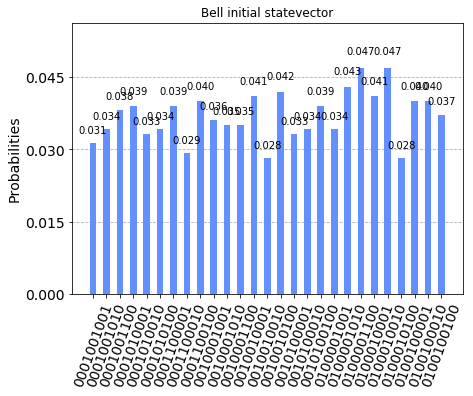

In [293]:
simulator = Aer.get_backend('qasm_simulator')
# Execute and get counts
result = execute(k_col.circ, simulator).result()
counts = result.get_counts(k_col.circ)
plot_histogram(counts, title="Bell initial statevector")